In [1]:
from sympy import *

In [2]:
S, E, I, A, Q, R, D = symbols('S E I A Q R D')
Sq, Eq, Iq, Aq = symbols('Sq Eq Iq Aq') 
tau, sigma, alpha, lambd1, lambd2, mu, zeta, beta = symbols('tau sigma alpha lambda gamma mu zeta beta')
r, rho, p = symbols('r rho p')

In [3]:
ds = -beta*S*(I+A+r*(Iq+Aq))
dsq = -r*beta*S*(I+A+r*(Iq+Aq))
de = beta*S*(I+A+r*(Iq+Aq))-rho*zeta*E-tau*E
deq = beta*Sq*(I+A+r*(Iq+Aq))-rho*zeta*Eq-tau*Eq
di = tau*E-sigma*I-rho*I
diq = tau*Eq-sigma*Iq-rho*Iq 
da = alpha*sigma*I-rho*A-lambd1*A
daq = alpha*sigma*Iq-rho*Aq-lambd1*Aq
dq = sigma*(1-alpha)*(I+Iq)+rho*(zeta*(E+Eq)+I+Iq+A+Aq)-lambd2*Q-mu*Q
dr = lambd1*(A+Aq)+lambd2*Q
dd = mu*Q

Simulando o modelo

In [5]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.widgets import Slider, Button, RadioButtons
from IPython.html.widgets import *

In [95]:
def f(xs,t,ps):
    
    try:
        tau = ps['tau'].value
        sigma = ps['sigma'].value
        alpha = ps['alpha'].value
        lambd1 = ps['lambd1'].value
        lambd2 =ps['lambd2'].value
        mu =ps['mu'].value
        mu2 =ps['mu2'].value
        tmu = ps['tmu'].value
        delta =ps['delta'].value
        beta =ps['beta'].value
        r =ps['r'].value
        rho = ps['rho'].value
        p = ps['p'].value
        p2 = ps['p2'].value
        tp = ps['tp'].value
    except:
        
        tau, sigma, alpha, lambd1, lambd2, mu,mu2,tmu, delta, beta, r, rho, p, p2, tp = ps
        
    St, E, Eq, I, Iq, A, Aq, Q, R, D = xs
    
    
    if t > tp: p = p2
    if t > tmu: mu = mu2
    
    S = (1-p)*St
    Sq = p*St
    
    return [
        -beta*S*(I+A+r*(Iq+Aq))-r*beta*Sq*(I+A+r*(Iq+Aq)),
        beta*S*(I+A+r*(Iq+Aq))-rho*delta*E-tau*E,
        r*beta*Sq*(I+A+r*(Iq+Aq))-rho*delta*Eq-tau*Eq,
        tau*E-sigma*I-rho*I,
        tau*Eq-sigma*Iq-rho*Iq,
        alpha*sigma*I-rho*A-lambd1*A,
        alpha*sigma*Iq-rho*Aq-lambd1*Aq,
        sigma*(1-alpha)*(I+Iq)+rho*(delta*(E+Eq)+I+Iq+A+Aq)-lambd2*Q-mu*Q,
        lambd1*(A+Aq)+lambd2*Q,
        mu*Q
           ]

def g(t, x0, ps):
    St = 1 - np.sum(x0)
    x0 = np.insert(x0,0,St)
    x = odeint(f,x0, t, args = (ps,))
    return x


def residual(ps, ts, data):
    x0 = ps['E'].value,ps['Eq'].value,ps['I'].value,ps['Iq'].value,ps['A'].value,ps['Aq'].value,ps['Q'].value,ps['R'].value,ps['D'].value
    model = g(ts, x0, ps)
    
    #teste
    model = model[:,4]+model[:,5]
    model *= 8.3*10e6
    return (model - data).ravel()

In [96]:
t = np.linspace(0,251,251)
x0 = np.array([10e-6,0,0,0,0,0,0,0,0])

tau = 1/3
sigma = 0.5
alpha = 0.6
lambd1 = 1/8
lambd2 = 1/16
mu = 0.05
mu2 = 0.01
tmu = 60
delta = 1
beta = 0.8
r = 0.5
rho = 0.05
p = 0
p2 = 0.8
tp = 30

t_params = np.array((tau, sigma, alpha, lambd1, lambd2, mu, mu2, tmu, delta, beta, r, rho, p, p2, tp))

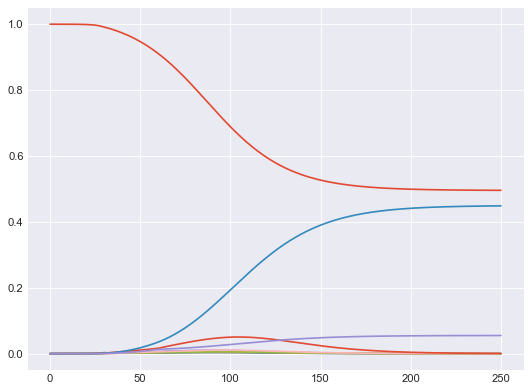

In [97]:
sol = g(t,x0,t_params)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

for i in range(10):
    plt.plot(sol[:,i])
    
plt.show()

In [9]:
from lmfit import minimize, Parameters, Parameter, report_fit
df = pd.read_csv("COVID-19_Daily_Counts_of_Cases__Hospitalizations__and_Deaths.csv")
df

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,02/29/2020 12:00:00 AM,1,0,0
1,03/03/2020 12:00:00 AM,1,1,0
2,03/04/2020 12:00:00 AM,5,2,0
3,03/05/2020 12:00:00 AM,3,8,0
4,03/06/2020 12:00:00 AM,8,5,0
...,...,...,...,...
246,11/03/2020 12:00:00 AM,756,58,11
247,11/04/2020 12:00:00 AM,860,47,6
248,11/05/2020 12:00:00 AM,581,37,6
249,11/06/2020 12:00:00 AM,305,3,5


In [ ]:
ny = df[['CASE_COUNT','HOSPITALIZED_COUNT','DEATH_COUNT']].to_numpy()
cases = df[['CASE_COUNT']].to_numpy()

#transformando uma lista de listas em uma lista
cases = cases.ravel()[:251]

In [ ]:
ny_cases = ny[:,0]

In [26]:
params = Parameters()

#adicionando todos parametros necessarios para rodar o modelo

#tratamos as condiçoes inicias como parametros tb
params.add('E', value=0.0, min=0, max=1,vary= False)
params.add('Eq', value=0.0, min=0, max=1, vary= False)
params.add('R', value=0.0, min=0, max=1, vary= False)
params.add('A', value=0.0, min=0, max=1, vary= False)
params.add('Aq', value=0.0, min=0, max=1, vary= False)
params.add('Q', value=0.0, min=0, max=1, vary= False)
params.add('D', value=0.0, min=0, max=1, vary= False)
params.add('I', value=5.0818e-05, min=0, max=10e-4, vary= True)
params.add('Iq', value=0, min=0, max=1, vary= False)

#parametros do modelo
params.add('tau', value=0.16584206, min=0, max=1)
params.add('sigma', value=0.70116841, min=0, max=1)
params.add('alpha', value=0.46800622, min=0, max=1)
params.add('lambd1', value=8.7054e-04, min=0, max=1)
params.add('lambd2', value=0.14662076, min=0, max=1)
params.add('mu', value=0.32584105, min=0, max=1)
params.add('mu2', value=0.10126612, min=0, max=1)
params.add('tmu', value=60, min=0, max=251)
params.add('delta', value=1, min=0, max=1)
params.add('beta', value=0.64846010, min=0, max=1)
params.add('r', value=0.50337656, min=0, max=1)
params.add('rho', value=0.13904760, min=0, max=1)
params.add('p', value=0.00398849, min=0, max=1)
params.add('p2', value=0.74907787, min=0, max=1)
params.add('tp', value=34.7148268, min=0, max=251)


result = minimize(residual, params, args = (t,ny_cases), method= 'leastsq')

In [27]:
final = ny_cases + result.residual.reshape(ny_cases.shape)

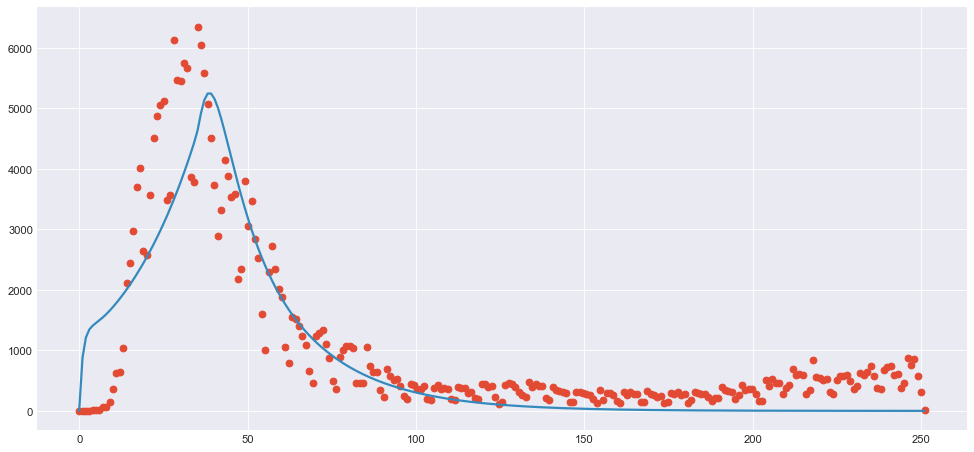

In [18]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, ny_cases, 'o')
plt.plot(t, final, '-', linewidth=2)

In [16]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 400
    # data points      = 251
    # variables        = 16
    chi-square         = 1.1110e+08
    reduced chi-square = 472773.064
    Akaike info crit   = 3295.12634
    Bayesian info crit = 3351.53359
##  Warning: uncertainties could not be estimated:
    tmu:     at initial value
[[Variables]]
    E:       0 (fixed)
    Eq:      0 (fixed)
    R:       0 (fixed)
    A:       0 (fixed)
    Aq:      0 (fixed)
    Q:       0 (fixed)
    D:       0 (fixed)
    I:       5.0818e-05 (init = 1e-05)
    Iq:      0 (fixed)
    tau:     0.16584206 (init = 0.3)
    sigma:   0.70116841 (init = 0.5)
    alpha:   0.46800622 (init = 0.6)
    lambd1:  8.7054e-04 (init = 0.125)
    lambd2:  0.14662076 (init = 0.0625)
    mu:      0.32584105 (init = 0.5)
    mu2:     0.10126612 (init = 0.1)
    tmu:     60.0000000 (init = 60)
    delta:   0.99996738 (init = 1)
    beta:    0.64846010 (init = 0.8)
    r:       0.50337656 (ini

In [91]:
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

In [ ]:
ode_model = DifferentialEquation(
    func=f,
    times= t, 
    n_states=10,
    n_theta=15,
    t0=0,
)

with pm.Model() as model:
    
    sigma1 = pm.HalfCauchy('sigma1', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    #R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    #lam = pm.Lognormal('lambda', pm.math.log(2), 2)
    #beta = pm.Deterministic('beta', lam * R0)
    tau =  pm.Lognormal('tau',1/3
    sigma =  pm.Lognormal('sigma',pm.math.log(0.5),0.5)
    alpha =  pm.Lognormal('alpha',pm.math.log(0.6),0.6)
    lambd1 =  pm.Lognormal('lambd1,'pm.math.log(1/8),1/8)
    lambd2 =  pm.Lognormal('lambd2',pm.math.log(1/16),1/16)
    mu =  pm.Lognormal('mu',pm.math.log(0.05),0.05)
    mu2 =  pm.Lognormal('mu2',pm.math.log(0.01),0.01)
    tmu =  pm.Lognormal('tmu',pm.math.log(60),3)
    delta =  pm.Lognormal('delta',pm.math.log(1),1)
    beta =  pm.Lognormal('beta',pm.math.log(0.8),0.8)
    r =  pm.Lognormal('r',pm.math.log(0.5),0.5)
    rho =  pm.Lognormal('rho',pm.math.log(0.05),0.05)
    p =  pm.Lognormal('p',pm.math.log(0.01),0.01)
    p2 =  pm.Lognormal('p2',pm.math.log(0.8),0.8)
    tp =  pm.Lognormal('tp',pm.math.log(30),3)
    

    ode_curves = ode_model(y0=[0.99, 0.01], theta=[beta, lam])

    Y = pm.Lognormal('Y', mu=pm.math.log(ode_curves), sigma=sigma1, observed=yobs)

    trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=1)
    data = az.from_pymc3(trace=trace)

In [ ]:
tau = 1/3
sigma = 0.5
alpha = 0.6
lambd1 = 1/8
lambd2 = 1/16
mu = 0.05
mu2 = 0.01
tmu = 60
delta = 1
beta = 0.8
r = 0.5
rho = 0.05
p = 0
p2 = 0.8
tp = 30

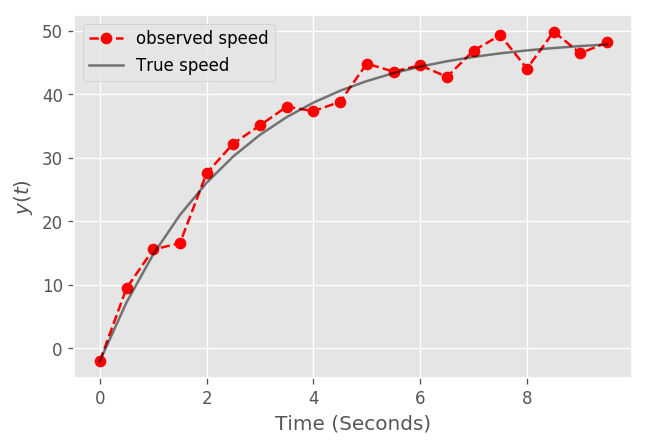

In [423]:
# For reproducibility
np.random.seed(20394)

def freefall(y, t, p):
    return 2.0 * p[1] - p[0] * y[0]

# Times for observation
times = np.arange(0,10,0.5)
gamma, g, y0, sigma = 0.4, 9.8, -2, 2
y = odeint(freefall, t=times, y0=y0, args=tuple([[gamma, g]]))
yobs = np.random.normal(y,2)

fig, ax = plt.subplots(dpi=120)
plt.plot(times, yobs, label='observed speed', linestyle='dashed', marker='o', color='red')
plt.plot(times, y, label='True speed', color='k', alpha=0.5)
plt.legend()
plt.xlabel('Time (Seconds)')
plt.ylabel(r'$y(t)$');
plt.show()

In [426]:
ode_model = DifferentialEquation(
    func=freefall,
    times=times,
    n_states=1,
    n_theta=2,
    t0=0
)

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    sigma = pm.HalfCauchy('sigma', 1)
    gamma = pm.Lognormal('gamma',0, 1)

    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=[0], theta=[gamma, 9.8])
    # The ode_solution has a shape of (n_times, n_states)

    Y = pm.Normal('Y', mu=ode_solution, sigma=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=100, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, sigma]


Sampling 2 chains for 100 tune and 2_000 draw iterations (200 + 4_000 draws total) took 535 seconds.
The acceptance probability does not match the target. It is 0.9275254250551863, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9255957525271727, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


NameError: name 'az' is not defined

In [428]:
 data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



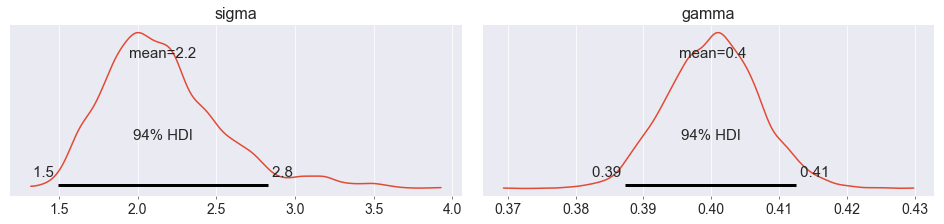

In [429]:
az.plot_posterior(data, figsize=(13,3));

TypeError: point() missing 1 required positional argument: 'idx'

In [462]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

In [445]:
model.basic_RVs

[mu, obs]

In [468]:
model.logp({"mu": 0})

array(-141.48413624)

In [85]:
import pystan

In [86]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code)
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19a09b474d1901f191444eaf8a6b8ce2 NOW.


In [87]:
fit2 = sm.sampling(data=schools_dat, iter=10000, chains=4)

In [88]:
la = fit.extract(permuted=True)  # return a dictionary of arrays
mu = la['mu']

## return an array of three dimensions: iterations, chains, parameters
a = fit.extract(permuted=False)

In [89]:
print(fit)

Inference for Stan model: anon_model_19a09b474d1901f191444eaf8a6b8ce2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
mu          7.78    0.18   5.18  -3.21   4.38    7.95  11.22   17.8    827    1.0
tau         6.43    0.18   5.34   0.26    2.4    5.08   9.06  20.89    846    1.0
eta[1]      0.39    0.02   0.95  -1.63  -0.22    0.42    1.0   2.23   2005    1.0
eta[2]   -4.3e-3    0.02    0.9   -1.8  -0.58  7.9e-3   0.57   1.75   2240    1.0
eta[3]     -0.19    0.02   0.93  -1.96   -0.8   -0.19   0.43   1.59   2160    1.0
eta[4]    1.7e-3    0.02    0.9  -1.79   -0.6 -4.7e-3   0.59    1.8   1969    1.0
eta[5]     -0.37    0.02   0.89  -2.16  -0.95   -0.37   0.22    1.4   1904    1.0
eta[6]      -0.2    0.02    0.9  -1.93   -0.8   -0.21   0.42   1.56   1773    1.0
eta[7]      0.34    0.02   0.93  -1.63  -0.25    0.38   0.95   2.12   2002 

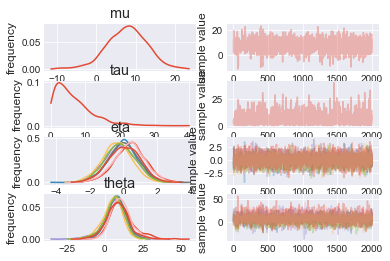

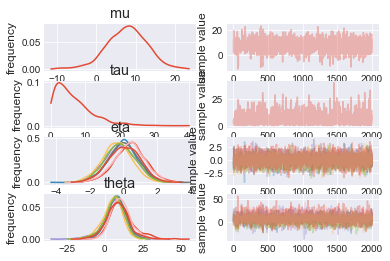

In [90]:
fit.plot()